# Аналитика окупаемости рекламы развлекательного приложения

**Описание проекта**

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.

<b> Цели и задачи </b> 

- Выяснить, окупается ли реклама, направленная на привлечение пользователей в целом.
- Понять, какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы.
- Разобраться, чем могут быть вызваны проблемы окупаемости.
- Описать возможные причины обнаруженных проблем.
- Дать промежуточные рекомендации для рекламного отдела.

<b> Описание данных </b>

В нашем распоряжении три датасета. 
- `visits_info_short.csv` — хранит лог сервера с информацией о посещениях сайта
- `orders_info_short.csv` — информацию о заказах
- `costs_info_short.csv` — информацию о расходах на рекламу

Структура `visits_info_short.csv`:
- User Id — уникальный идентификатор пользователя
- Region — страна пользователя
- Device — тип устройства пользователя
- Channel — идентификатор источника перехода
- Session Start — дата и время начала сессии
- Session End — дата и время окончания сессии

Структура `orders_info_short.csv`:
- User Id — уникальный идентификатор пользователя
- Event Dt — дата и время покупки
- Revenue — сумма заказа

Структура `costs_info_short.csv`:
- dt — дата проведения рекламной кампании
- Channel — идентификатор рекламного источника
- costs — расходы на эту кампанию

<b> План анализа данных </b> 

1. [Загрузка и предобработка данных](#1)  
2. [Задание функций для расчёта и анализа LTV, ROI, удержания и конверсии](#2)  
   - [get_profiles - Функция для создания профилей пользователей](#2.1)  
   - [get_retention - Функция для подсчёта Retention Rate](#2.2)  
   - [get_conversion - Функция для подсчёта конверсии](#2.3)  
   - [get_ltv - функция для подсчёта LTV и ROI](#2.4)  
   - [filter_data - Функция для сглаживания фрейма данных](#2.5)  
   - [plot_retention - Функция для построения графика Retention Rate](#2.6)  
   - [plot_conversion - Функция для построения графика конверсии](#2.7)  
   - [plot_ltv_roi - Функция для визуализации LTV и ROI](#2.8)  
3. [Исследовательский анализ данных](#3)  
   - [Составление профилей пользователей](#3.1)
   - [Распределение пользователей по странам, количество и доля платящих](#3.2)
   - [Распределение пользователей по устройствам, количество и доля платящих](#3.3)
   - [Распределение пользователей по рекламным источникам, количество и доля платящих](#3.4)
4. [Маркетинговая часть](#4)
   - [Общая сумма расходов на маркетинг](#4.1)
   - [Распределение затрат по рекламным источникам](#4.2)
   - [Визуализация динамики изменения расходов по каждому источнику](#4.3)
   - [Средняя стоимость привлечения одного пользователя из каждого источника](#4.4)
5. [Оценка окупаемости рекламы](#5)
   - [Окупаемость рекламы на графиках LTV и ROI, графики динамики LTV, CAC и ROI](#5.1)
   - [Конверсия пользователей, динамика её измененя, удержание пользователей](#5.2)
   - [Окупаемость рекламы с разбивкой по устройствам. Графики LTV и ROI, графики динамики LTV, CAC и ROI](#5.3)
   - [Конверсия пользователей с разбивкой по устройствам, динамика её измененя](#5.4)
   - [Удержание пользователей с разбивкой по устройствам, динамика его измененя](#5.5)
   - [Окупаемость рекламы с разбивкой по странам. Графики LTV и ROI, графики динамики LTV, CAC и ROI](#5.6)
   - [Конверсия пользователей с разбивкой по странам, динамика её измененя ](#5.7)
   - [Удержание пользователей с разбивкой по странам, динамика его измененя](#5.8)
   - [Окупаемость рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, графики динамики LTV, CAC и ROI](#5.9)
   - [Конверсия пользователей с разбивкой по каналам привлечения, динамика её измененя ](#5.10)
   - [Удержание пользователей с разбивкой по рекламным каналам, динамика его измененя](#5.11)
   - [Изучиение отдельно рекламы в США ](#5.12)
6. [Вывод](#6)

## Загрузка и предобработка данных <a id='1'></a>

In [1]:
#импортируем библиотеки
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
def get_df(file_name:str, sep=','):
    '''Функция получения датасета.  
    
    Пытается получить датасет из трех директорий:  
    - из текущей папки;  
    - из папки `datasets`;  
    - из папки `../datasets`.'''
    path_1 = os.path.join('datasets', file_name)
    path_2 = os.path.join('../datasets', file_name)
    if os.path.exists(file_name):
        df = pd.read_csv(file_name, sep=sep)
        return df
    elif os.path.exists(path_1):
        df = pd.read_csv(path_1, sep=sep)
        return df
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2, sep=sep)
        return df
    else:
        print('File is not found')

In [3]:
#загружаем датасеты
visits, orders, costs = (
    get_df('visits_info_short.csv'),
    get_df('orders_info_short.csv'),
    get_df('costs_info_short.csv')
)

In [4]:
#сделаем список с пременными датасетов, чтобы было удобнее проводить над ними повторяющиеся операции
datasets = [visits, orders, costs]

In [5]:
#посмотрим на данные, вызовем метод info
for i in datasets:
    display(i.head())
    i.info()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропусков в данных нет.

Требуется:

- Данныe о времени  перевести в формат datetime
- Переименовать названия столбцов
- Проверить данные на дубликаты

In [6]:
#переименовываем и приводим к нижнему регистру названия столбцов
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [7]:
#смотрим дубликаты
for i in datasets:
    display(i.duplicated().sum())

0

0

0

In [8]:
#данныe о времени переводим в формат datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [9]:
#смотрим на датасеты
for i in datasets:
    display(i.head())

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

В нашем распоряжении 3 датафрейма: 
- visits - 309901 строк, 6 столбцов
- orders - 40212 строк, 3 столбца
- costs - 1800 строк, 3 столбца

Пропусков в данных нет. Дубликатов нет. Переименовали и привели к нижнему регистру названия столбцов, данныe о времени перевели в формат datetime.

## Задание функций для расчёта и анализа LTV, ROI, удержания и конверсии <a id='2'></a>

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV и ROI.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### get_profiles - Функция для создания профилей пользователей <a id='2.1'></a>

In [10]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs, event_names=[]):
    '''Функция для создания профилей пользователей'''
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### get_retention - Функция для подсчёта Retention Rate <a id='2.2'></a>

In [11]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''Функция для подсчёта Retention Rate'''
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        '''Функция для группировки таблицы по желаемым признакам'''
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### get_conversion - Функция для подсчёта конверсии <a id='2.3'></a>

In [12]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''Функция для подсчёта конверсии'''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        '''Функция для группировки таблицы по желаемым признакам'''
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### get_ltv - функция для подсчёта LTV и ROI <a id='2.4'></a>

In [13]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''функция для подсчёта LTV и ROI'''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        '''Функция группировки по желаемым признакам'''
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### filter_data - Функция для сглаживания фрейма данных <a id='2.5'></a>

In [14]:
# функция для сглаживания фрейма
def filter_data(df, window):
    '''Функция для сглаживания фрейма данных'''
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### plot_retention - Функция для построения графика Retention Rate <a id='2.6'></a>

In [15]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):
    '''Функция для построения графика Retention Rate'''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### plot_conversion - Функция для построения графика конверсии <a id='2.7'></a>

In [16]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):
    '''Функция для построения графика конверсии'''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### plot_ltv_roi - Функция для визуализации LTV и ROI <a id='2.8'></a>

In [17]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    '''Функция для визуализации LTV и ROI'''
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных <a id='3'></a>

### Составление профилей пользователей <a id='3.1'></a>

In [18]:
#получим профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))
profiles.shape

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt               month  payer  acquisition_cost  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237  
2  2019-10-01 2019-10-01 09:58:33  False          0.000000  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769

(150008, 9)

In [19]:
min_analysis_date = profiles['dt'].min() #самая ранняя дата привлечения пользователей
max_analysis_date = profiles['dt'].max() #самая поздняя дата привлечения пользователей
display('Cамая ранняя дата привлечения пользователей: {}'.format(min_analysis_date))
'Cамая поздняя дата привлечения пользователей: {}'.format(max_analysis_date)

'Cамая ранняя дата привлечения пользователей: 2019-05-01'

'Cамая поздняя дата привлечения пользователей: 2019-10-27'

С помощью функции составили профили пользователей. Имеем данные 150008 профилей пользователей, привлеченных с первого мая 2019 года по 27 октября 2019 года.

Исследование проводим от 1 ноября 2019 года, горизонт анализа 14 дней, даты совпадают с заданием.

### Распределение пользователей по странам, количество и доля платящих <a id='3.2'></a>

In [20]:
#для удобства сделаем срез по платящим пользователям, сохраним в переменной payers
payers = profiles.query('payer == True')

In [21]:
#далее будем строить однотипные таблицы, напишем функцию для их построения
def pivot(grouping):
    '''Функция построения сводных таблиц'''
    pivot = profiles.groupby(grouping).agg({'user_id':'count'})
    pivot['payers'] = payers.groupby(grouping).agg({'user_id':'count'})
    pivot['payers_ratio'] = pivot.payers / pivot.user_id
    pivot = pivot.sort_values('payers_ratio', ascending = False)
    pivot.columns = ['Пользователи', 'Платящие пользователи', 'Доля платящих']
    return pivot

In [22]:
#строим таблицу по странам, отражающую количество пользователей и долю платящих
countries = pivot('region')
countries

Пользователи  Платящие пользователи  Доля платящих
region                                                           
United States        100002                   6902       0.069019
Germany               14981                    616       0.041119
UK                    17575                    700       0.039829
France                17450                    663       0.037994

Две трети всех пользователей приложения из США. Доля платящих от неплатящих пользователей в этой стране больше, чем в других - 11%.

В остальных странах - Франция, Германия и Великобритания - доля всех пользователей около 10% в каждой, а доля платящих от неплатящих пользователей меньше - около 6%.

### Распределение пользователей по устройствам, количество и доля платящих  <a id='3.3'></a>

In [23]:
#строим таблицу по устройствам, отражающую количество пользователей и долю платящих
devices = pivot('device')
devices

Пользователи  Платящие пользователи  Доля платящих
device                                                     
Mac             30042                   1912       0.063644
iPhone          54479                   3382       0.062079
Android         35032                   2050       0.058518
PC              30455                   1537       0.050468

Большинства пользователей приложения на iPhone, количество платящих тоже.

Большая доля платящих на Mac и iPhone - 6,4 и 6,2% соответственно.

### Распределение пользователей по рекламным источникам, количество и доля платящих <a id='3.4'></a>

In [24]:
#строим таблицу по каналам привлечения, отражающую количество пользователей и долю платящих
channens = pivot('channel')
channens

Пользователи  Платящие пользователи  Доля платящих
channel                                                               
FaceBoom                   29144                   3557       0.122049
AdNonSense                  3880                    440       0.113402
lambdaMediaAds              2149                    225       0.104700
TipTop                     19561                   1878       0.096007
RocketSuperAds              4448                    352       0.079137
WahooNetBanner              8553                    453       0.052964
YRabbit                     4312                    165       0.038265
MediaTornado                4364                    156       0.035747
LeapBob                     8553                    262       0.030633
OppleCreativeMedia          8605                    233       0.027077
organic                    56439                   1160       0.020553

Большинство пользователей приложения сами его находят, почти 40% трафика - органический. Но этот вид трафика самый неконвертируемый - всего 2% органических пользователей совершают покупки в приложении.

Самая высокая доля платящих пользователей - 12,2% - из платформы FaceBoom, количество пользователей из этой платформы тоже значительное. Также много пользователей привлечено из платформы TipTop - их конвертация 9,6%

## Маркетинговая часть <a id='4'></a>

### Общая сумма расходов на маркетинг <a id='4.1'></a>

In [25]:
#считаем общую сумму расходов на рекламу
'Общая сумма расходов на маркетинг составила: {}'.format(round(costs.costs.sum(), 1))

'Общая сумма расходов на маркетинг составила: 105497.3'

### Распределение затрат по рекламным источникам <a id='4.2'></a>

In [26]:
#смотрим распределение затрат по рекламным источникам
channens_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False)
channens_costs['ratio'] = channens_costs.costs / channens_costs.costs.sum()
channens_costs

costs     ratio
channel                               
TipTop              54751.30  0.518983
FaceBoom            32445.60  0.307549
WahooNetBanner       5151.00  0.048826
AdNonSense           3911.25  0.037074
OppleCreativeMedia   2151.25  0.020392
RocketSuperAds       1833.00  0.017375
LeapBob              1797.60  0.017039
lambdaMediaAds       1557.60  0.014764
MediaTornado          954.48  0.009047
YRabbit               944.22  0.008950

Затраты на рекламу разделены неравномерно: больше половины рекламного бюджета потрачено на платформу TipTop. Также, почти треть потрачена на рекламу на платформе FaceBoom. В сумме на эти две площадки тратится более 80% всего рекламного бюджета. На остальные восемь площадок рекламные расходы составляют от 5 до 0.9 тыс. на каждую.

### Визуализация динамики изменения расходов по каждому источнику <a id='4.3'></a>

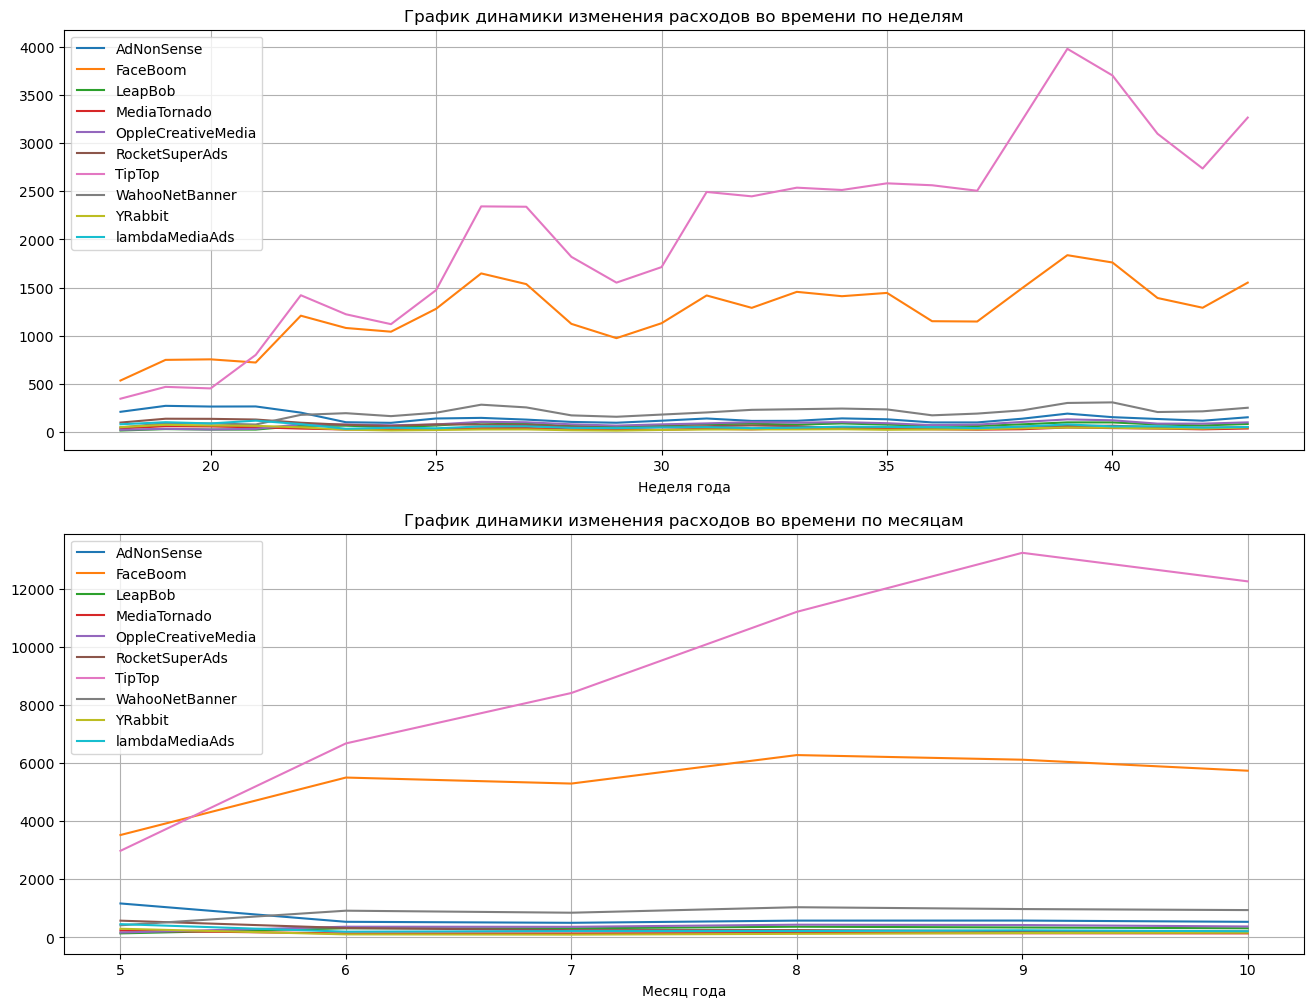

In [27]:
#Строим визуализацию динамики изменения расходов по неделям и месяцам по каждому источнику. 
marketing_costs = costs.copy()
marketing_costs['dt'] = pd.to_datetime(marketing_costs['dt'])
marketing_costs['week'] = marketing_costs.dt.dt.isocalendar().week
marketing_costs['month'] = marketing_costs.dt.dt.month

plt.figure(figsize=(16, 12))

ax1 = plt.subplot(2, 1, 1)
(marketing_costs
    .pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(grid=True,
          ax=ax1)
    )
plt.legend()
plt.xlabel('Неделя года')
plt.title('График динамики изменения расходов во времени по неделям')

ax2 = plt.subplot(2, 1, 2)
(marketing_costs
    .pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot(grid=True,
          ax=ax2)
    )
plt.legend()
plt.xlabel('Месяц года')
plt.title('График динамики изменения расходов во времени по месяцам')

plt.show()

Из графиков рекламных расходов по месяцам видим, что начиная с мая 2019 года расходы на площадках TipTop и FaceBoom постепенно увеличивались, достигнув своего пика в сентябре. При этом расходы на площадке TipTop к сентябрю достигли разницы почти в четыре раза, чем на старте рекламной кампании, разница расходов с платформой FaceBoom сильно увеличилась, достигнув разницы в два раза. На остальных рекламных площадках бюджет сравнительно не большой, и с течением времени не меняется. Из графика расходов по неделям можно отметить небольшие скачки расходов на рекламу на 22, 26-27 и 39 неделе.

### Средняя стоимость привлечения одного пользователя из каждого источника <a id='4.4'></a>

In [28]:
#смотрим, сколько в среднем стоило привлечение одного пользователя из каждого источника
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost', ascending=False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

In [29]:
'Cредний CAC на одного пользователя для всего проекта: {}'.format(round(profiles.acquisition_cost.mean(), 2))

'Cредний CAC на одного пользователя для всего проекта: 0.7'

Общая сумма расходов на маркетинг составила 105497.3$ 

Cредний CAC на одного пользователя для всего проекта: 1.13$

Затраты на рекламу разделены неравномерно: больше половины рекламного бюджета потрачено на платформу TipTop. Также, почти треть потрачена на рекламу на платформе FaceBoom. В сумме на эти две площадки тратится более 80% всего рекламного бюджета. На остальные восемь площадок рекламные расходы составляют от 5 до 0.9 тыс. на каждую.

Из графиков рекламных расходов по месяцам видим, что начиная с мая 2019 года расходы на площадках TipTop и FaceBoom постепенно увеличивались, достигнув своего пика в сентябре. При этом расходы на площадке TipTop к сентябрю достигли разницы почти в четыре раза, чем на старте рекламной кампании, разница расходов с платформой FaceBoom сильно увеличилась, достигнув разницы в два раза. На остальных рекламных площадках бюджет сравнительно не большой, и с течением времени не меняется. Из графика расходов по неделям можно отметить небольшие скачки расходов на рекламу на 22, 26-27 и 39 неделе.

Привлечение одного пользователя из платформы TipTop обходится дороже всех - в 2.5 раза дороже чем из FaceBoom, и в несколько раз дороже чем из остальных площадок.

## Оценка окупаемости рекламы <a id='5'></a>

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Окупаемость рекламы на графиках LTV и ROI, графики динамики LTV, CAC и ROI <a id='5.1'></a>

In [30]:
#чтобы правильно оценить эффективность рекламной кампании исключим из анализа органических пользователей
profiles = profiles.query('channel != "organic"')

In [31]:
#зададим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

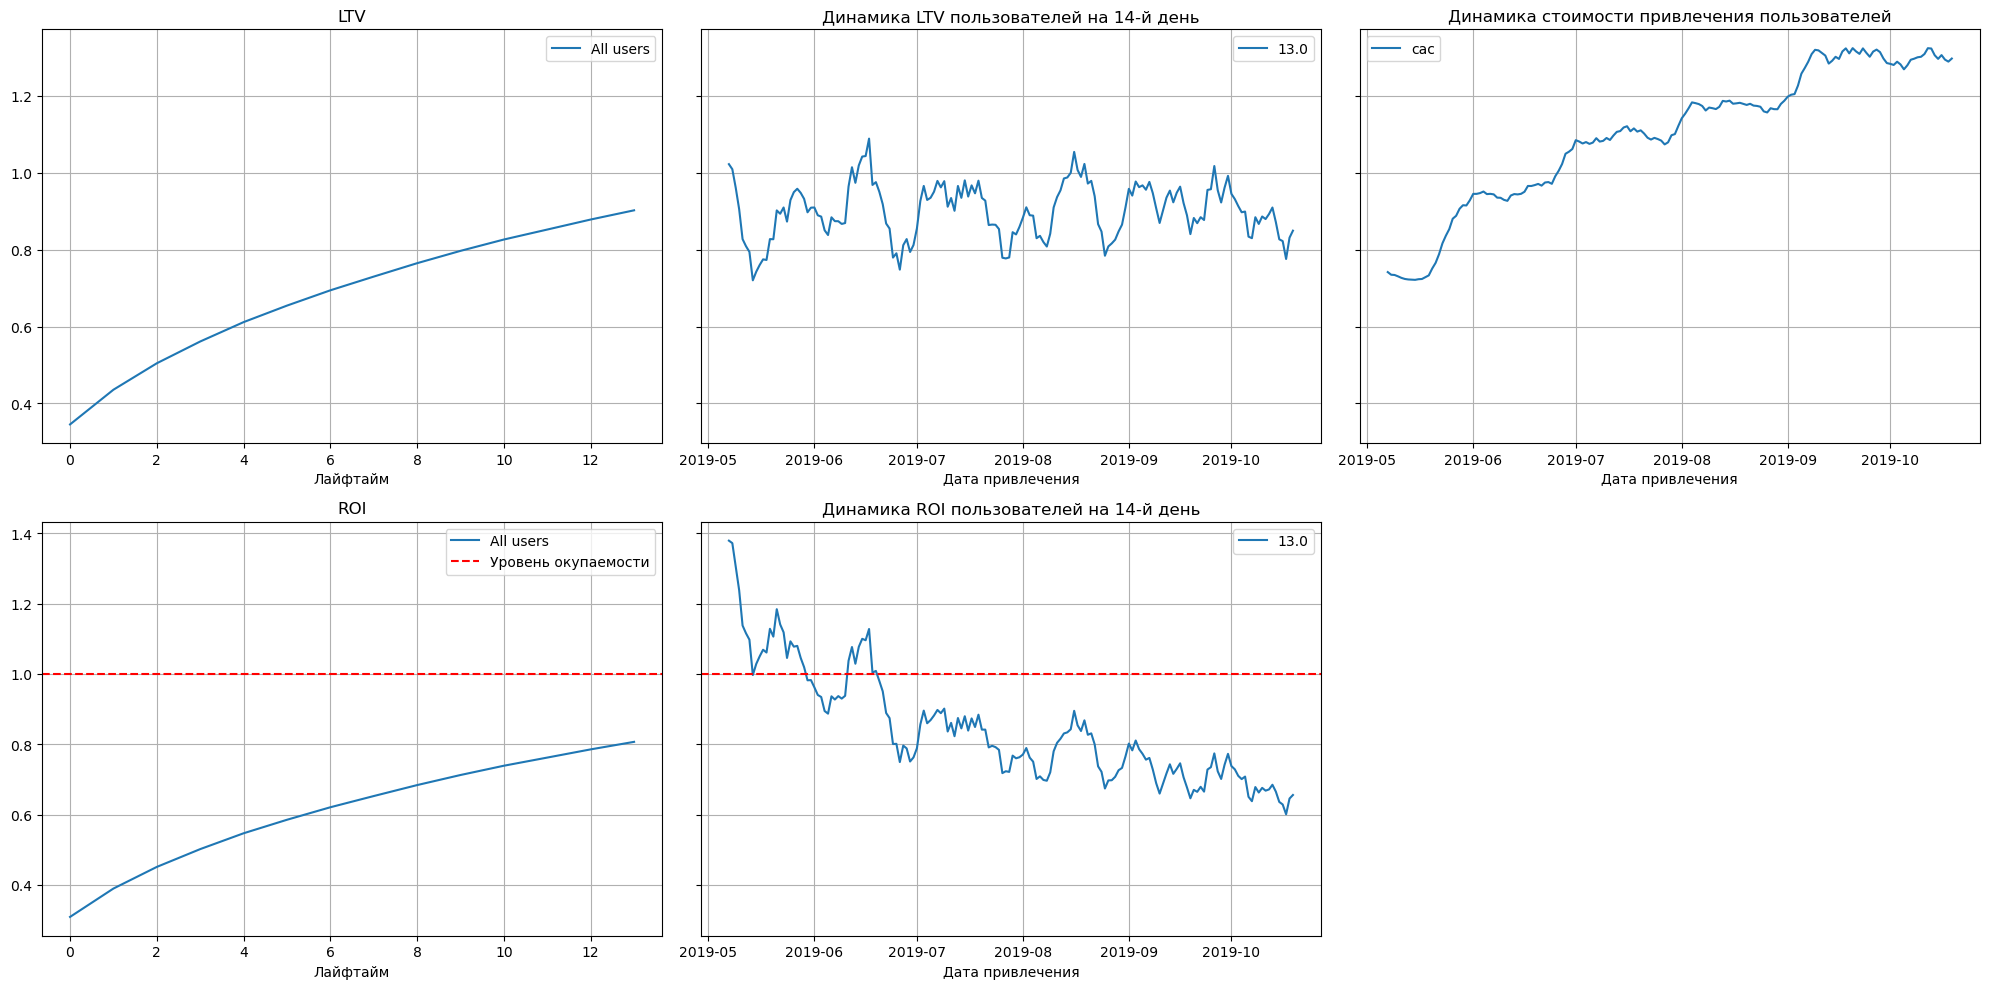

In [32]:
#строим графики LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графика ROI видим, что на 14-й лайфтайм пользователей показатель окупаемости рекламы не достигает отметки уровня окупаемости. При этом из графика динамики ROI на 14-й день видно, что реклама на старте кампании окупалась в 1.4 раза, далее в мае резкое снижение окупаемости до 1.0, с середины июня реклама перестала окупаться. 

Стоимость привлечения новых пользователей на протяжении всей рекламной компании увеличивалась. 

По графику LTV видно, что в первый день LTV составляет 0.4, к 14 дню достигает отметки 0.9. График LTV в динамике колеблется, но средний уровень сохраняется на отметке 0.9$ 

### Конверсия и удержание пользователей, динамика их измененя <a id='5.2'></a>

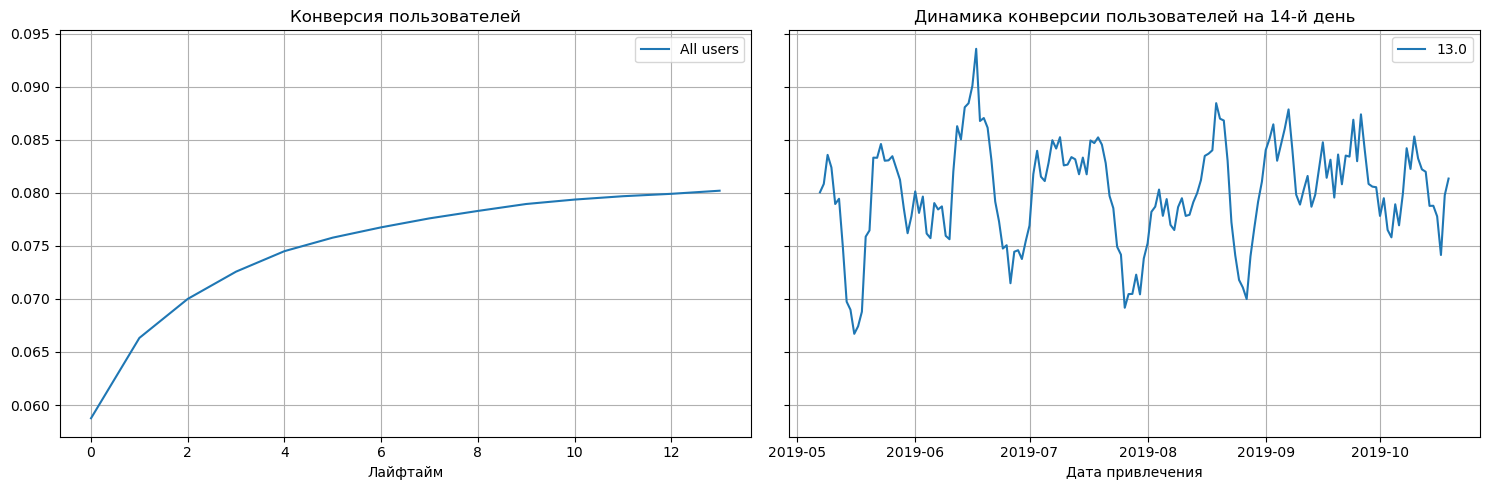

In [33]:
#строим график конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

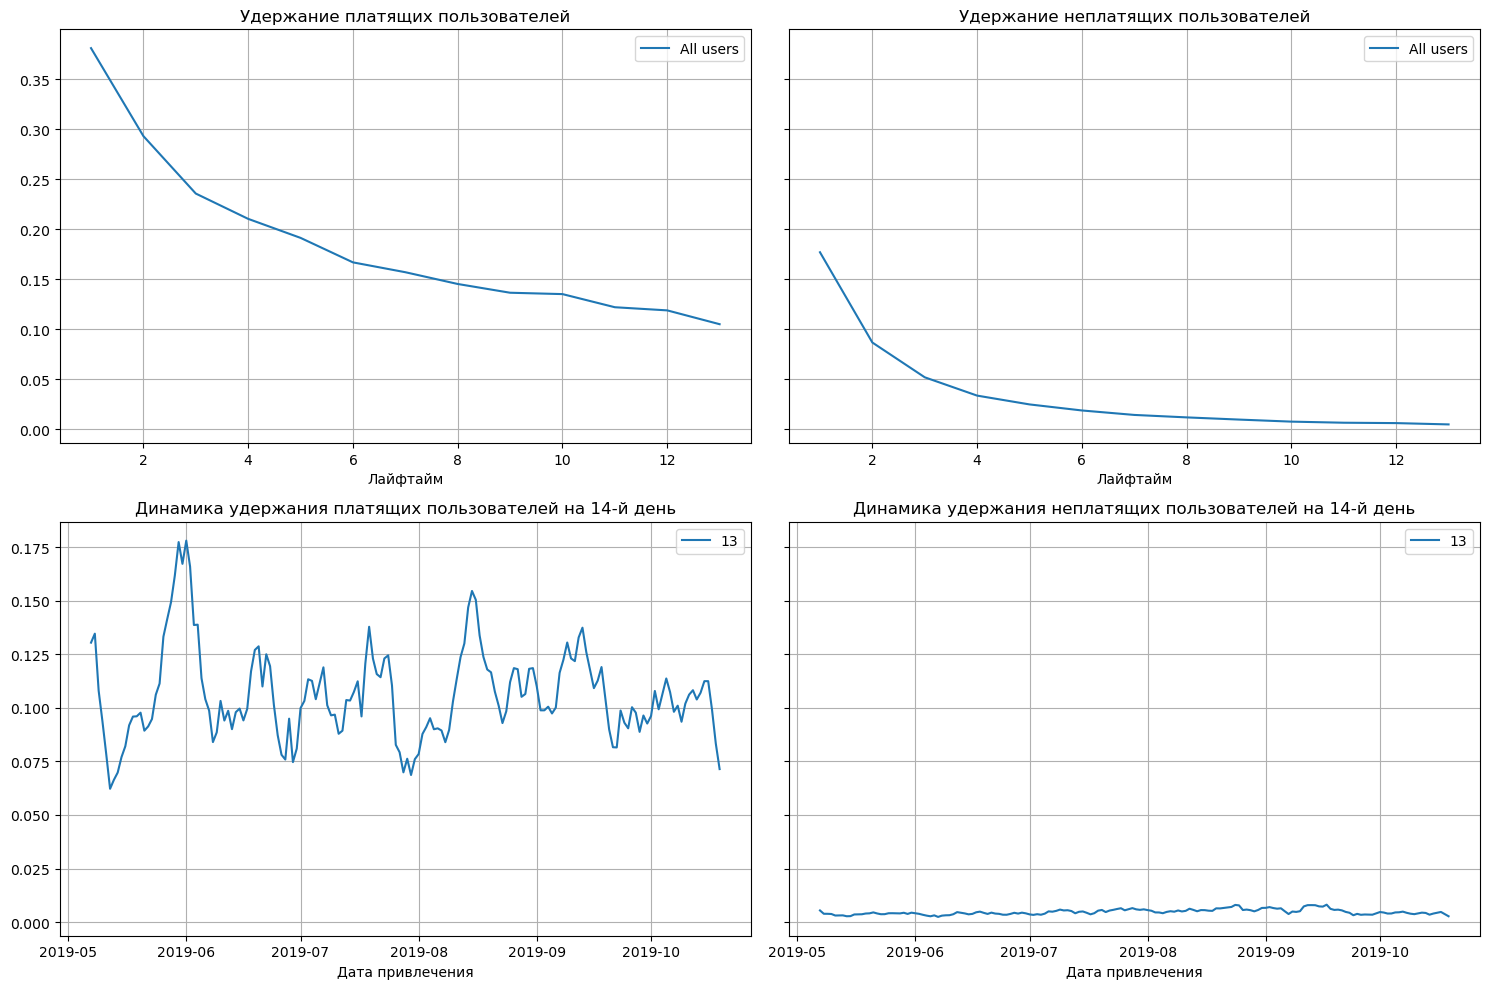

In [34]:
#строим график удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Из графика конверсии видно, что в первые два дня пользователи конвертируются с 6 до 7%, далее, к 14-му дню использования приложения, конверсия увеличивается до 8%. График динамики конверсии колеблется, но средний уровень конверсии сохраняется на отметке 8%

Динамика удержания неплатящих пользователей закономерно ниже платящих. В динамике удержания на 14-й день видно, что этот показатель снижался до 7,5% в мае, в конце июня, в конце июля. На момент анализа он также находится ниже 7,5%

### Окупаемость рекламы с разбивкой по устройствам. Графики LTV и ROI, графики динамики LTV, CAC и ROI <a id='5.3'></a>

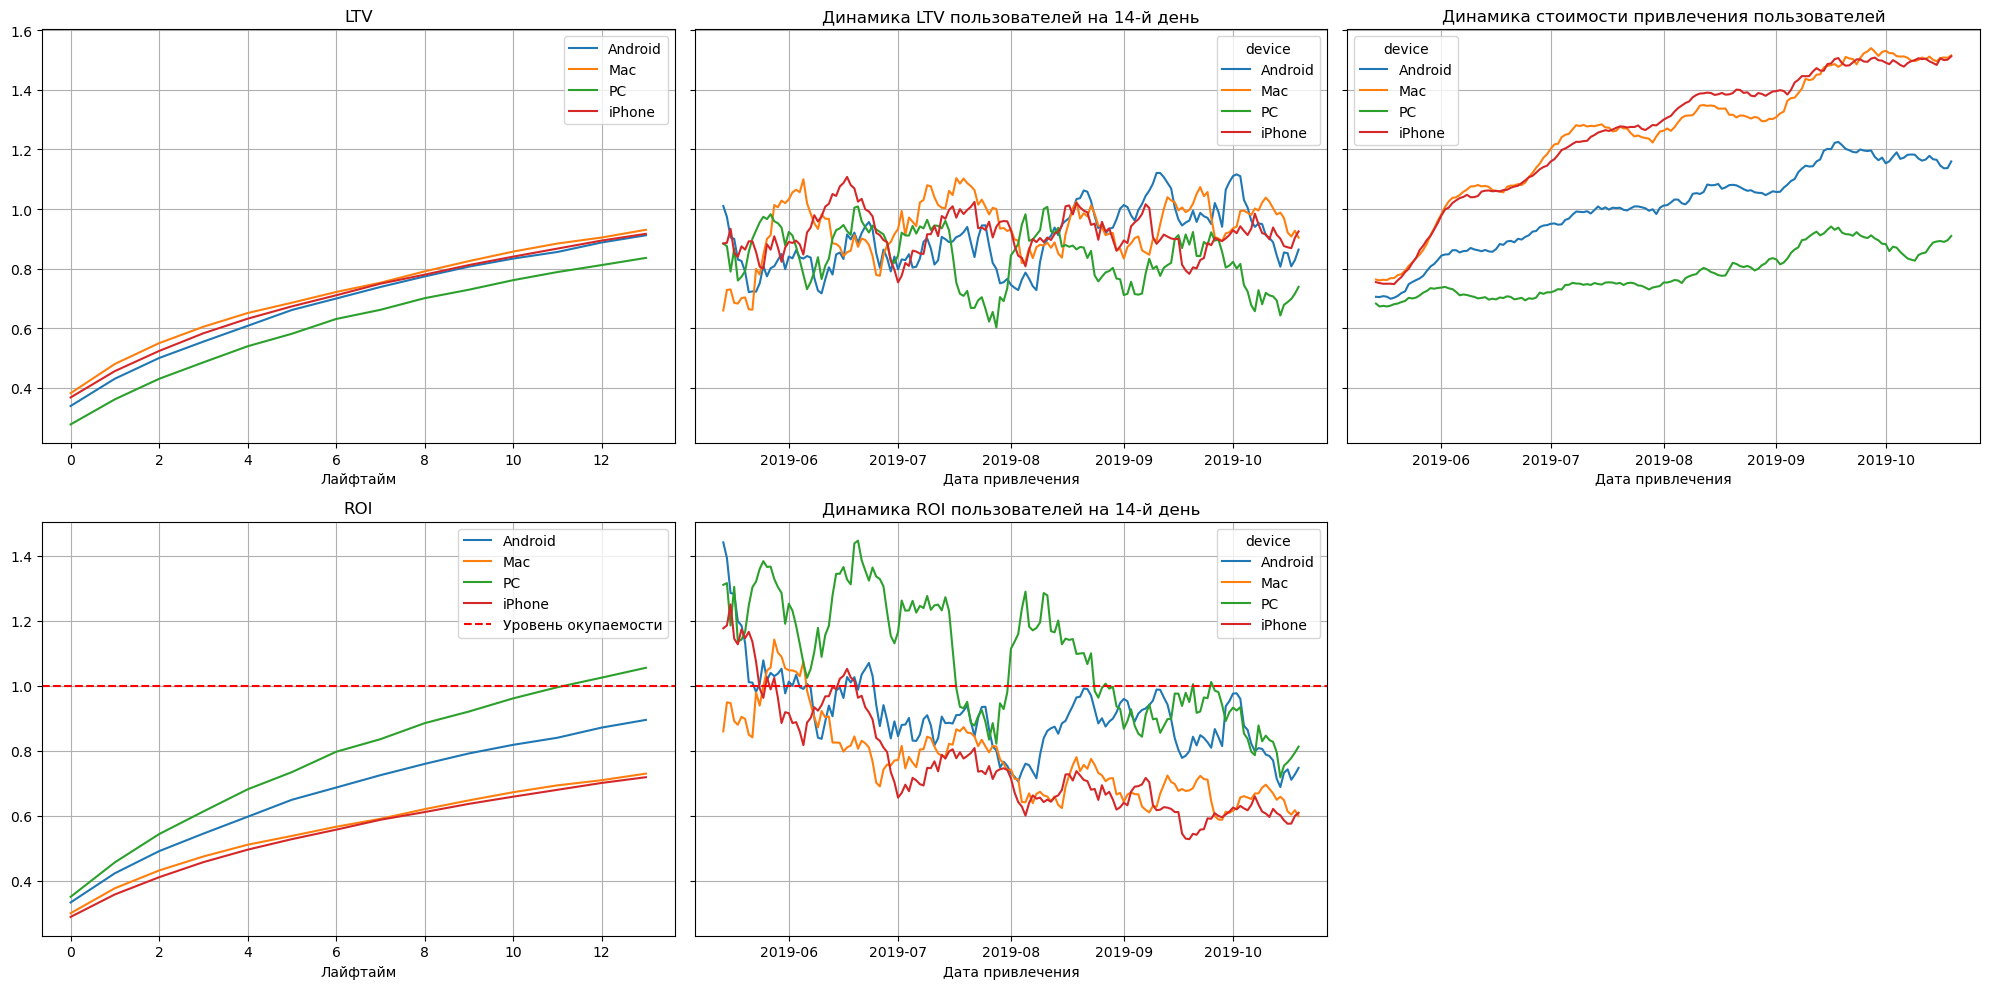

In [35]:
#строим графики LTV и ROI, динамики LTV, CAC и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Окупаемость пользователей для всех платформ стабильно снижается со временем. 
- Пользователи ПК окупаются к 12 дню использования приложения. На протяжении времени окупались до сентября. Стоимость привлечения пользователей на этой платформе ниже, чем на остальных.
- Пользователи Android не окупаются. На старте рекламной компании окупались в 1.5 раза, в июне их окупаемость опустилась ниже порогового значения.
- Пользователи iPhone и Mac не окупаются, показатели ROI и ROI в динамике ниже, чем других платформ. При этом стоимость привлечения пользователей на iPhone и Mac выше, чем на остальных платформах.

### Конверсия пользователей с разбивкой по устройствам, динамика её измененя <a id='5.4'></a>

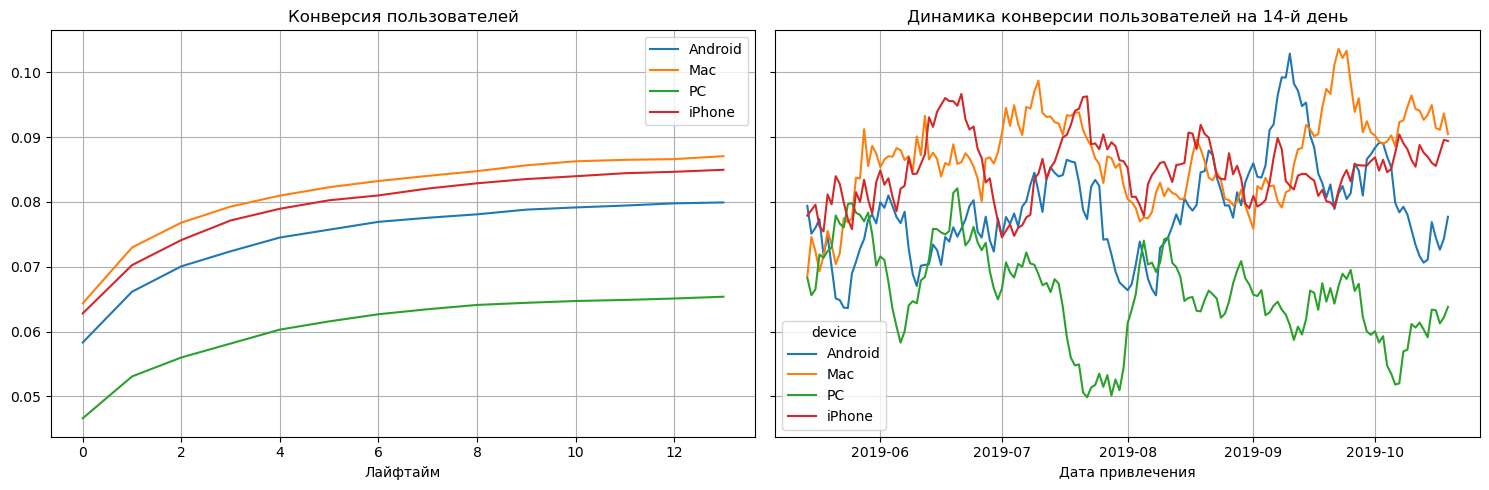

In [36]:
#смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Пользователи ПК всегда удерживались заметно хуже остальных платформ

### Удержание пользователей с разбивкой по устройствам, динамика его измененя  <a id='5.5'></a>

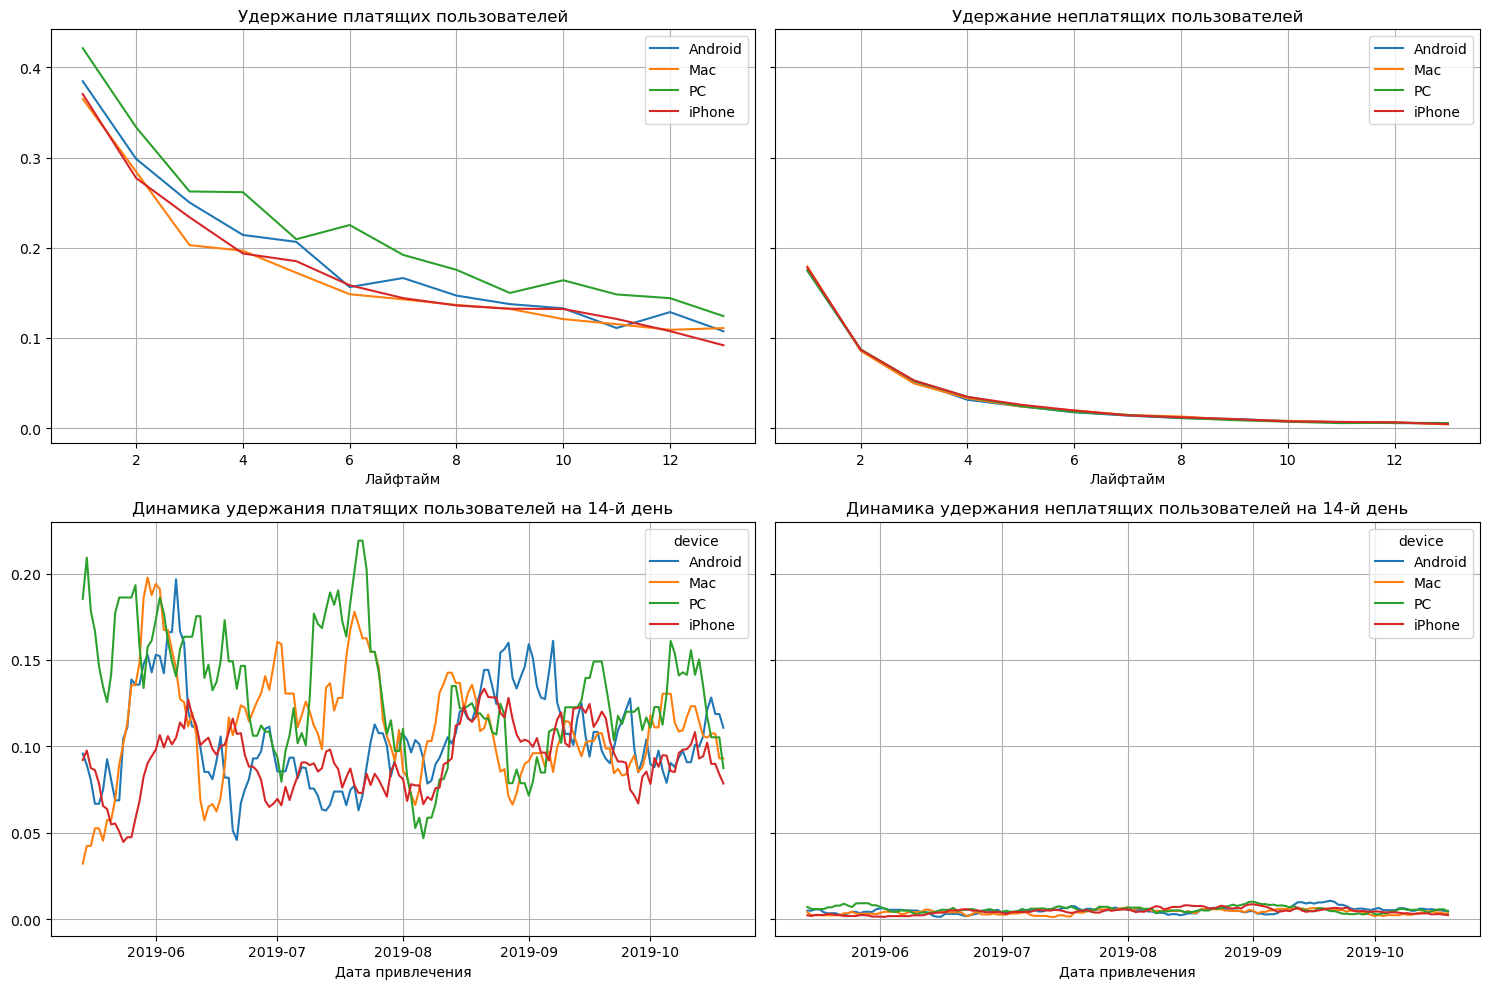

In [37]:
#посмотрим на графики удержания пользователей с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

На всех устройствах пользователи удерживаются примерно одинаково, технический фактор неисправности приложения на отдельной платформе можно исключить.

### Окупаемость рекламы с разбивкой по странам. Графики LTV и ROI, графики динамики LTV, CAC и ROI <a id='5.6'></a>

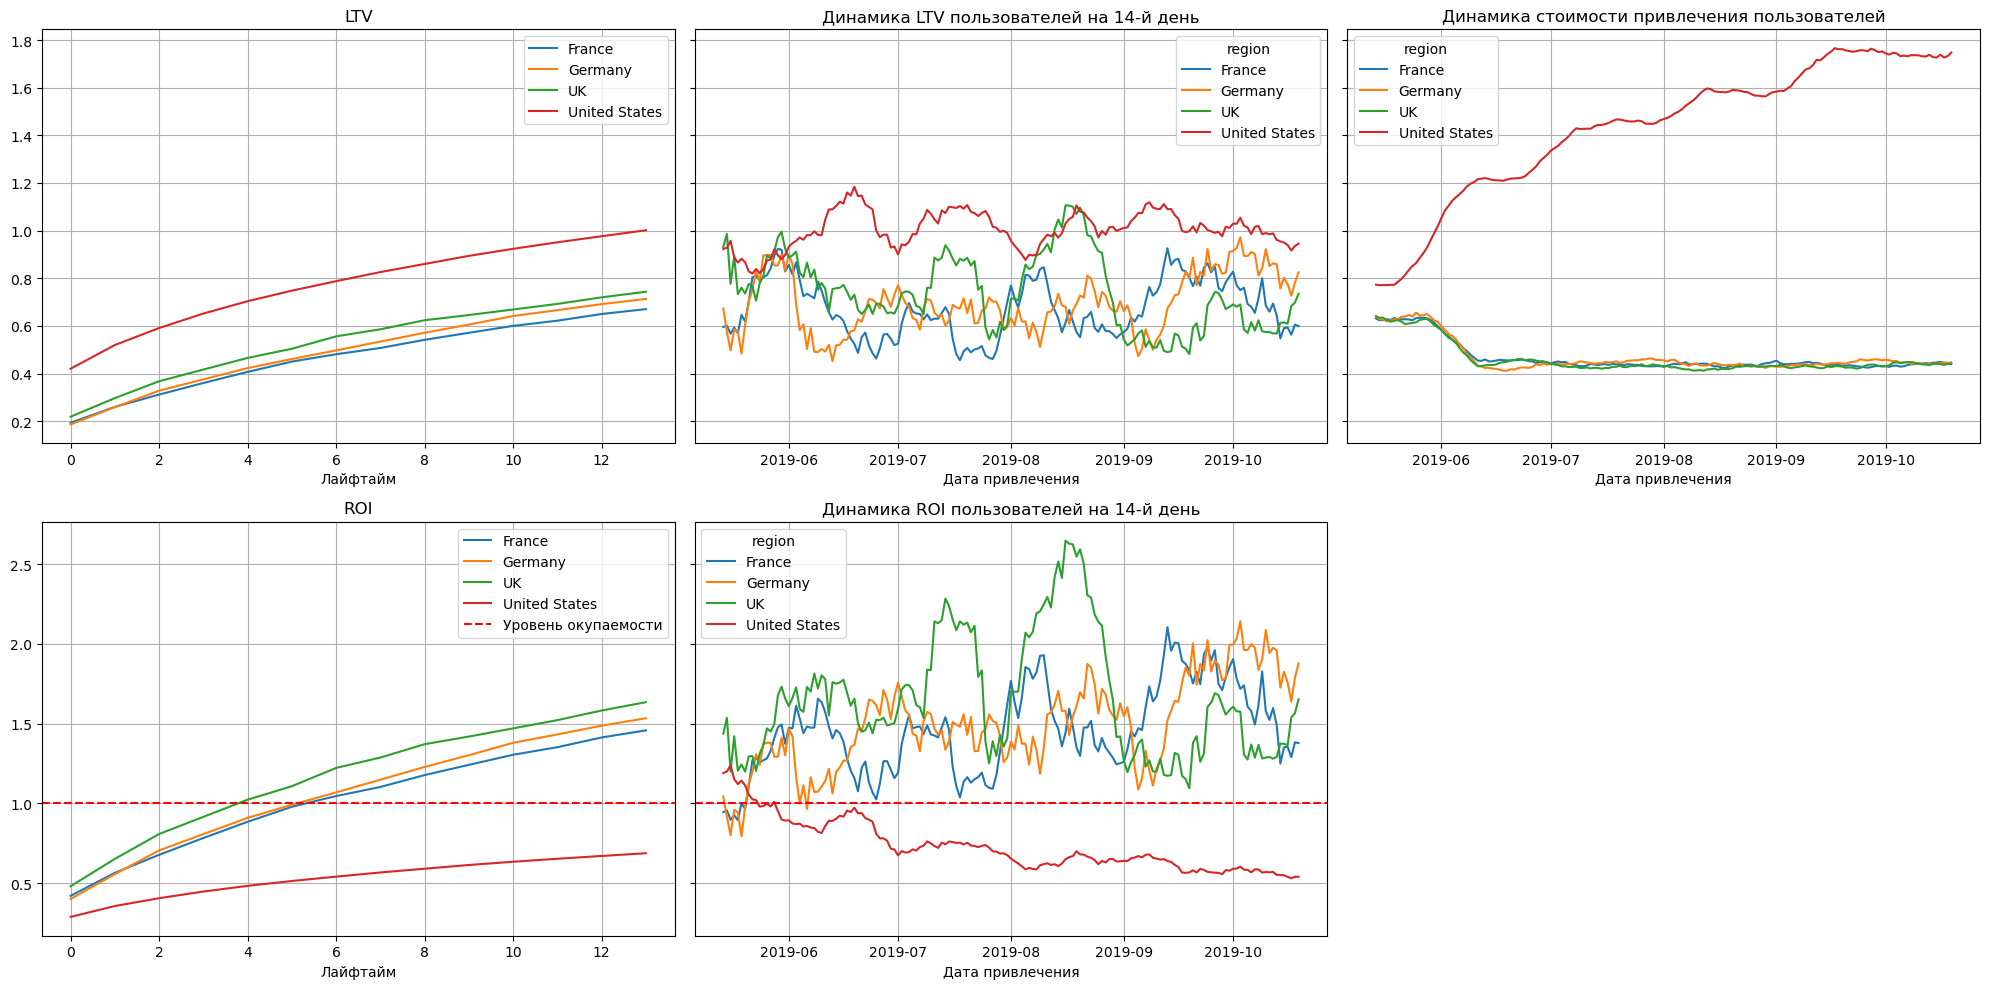

In [38]:
#строим графики LTV и ROI, динамики LTV, CAC и ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

В данном наборе графиков с разбивкой по странам очень выделяются пользователи из США: 
- LTV -  Lifetime value выше, чем в других странах. Динамика этого показателя на 14-й день тоже выше других стран. 
- CAC - Стоимость привлечения пользователей постоянно увеличивается, на момент анализа разница с другими странами почти в 4 раза.
- ROI - Пользователи из США не окупаются вообще, в отличие от пользователей из других стран, которые стабильно окупаются на 5-6 день. На старте рекламной кампании окупались, к июню окупаемость снизилась до порогового значения, с июля не окупаются.

### Конверсия пользователей с разбивкой по странам, динамика её измененя <a id='5.7'></a>

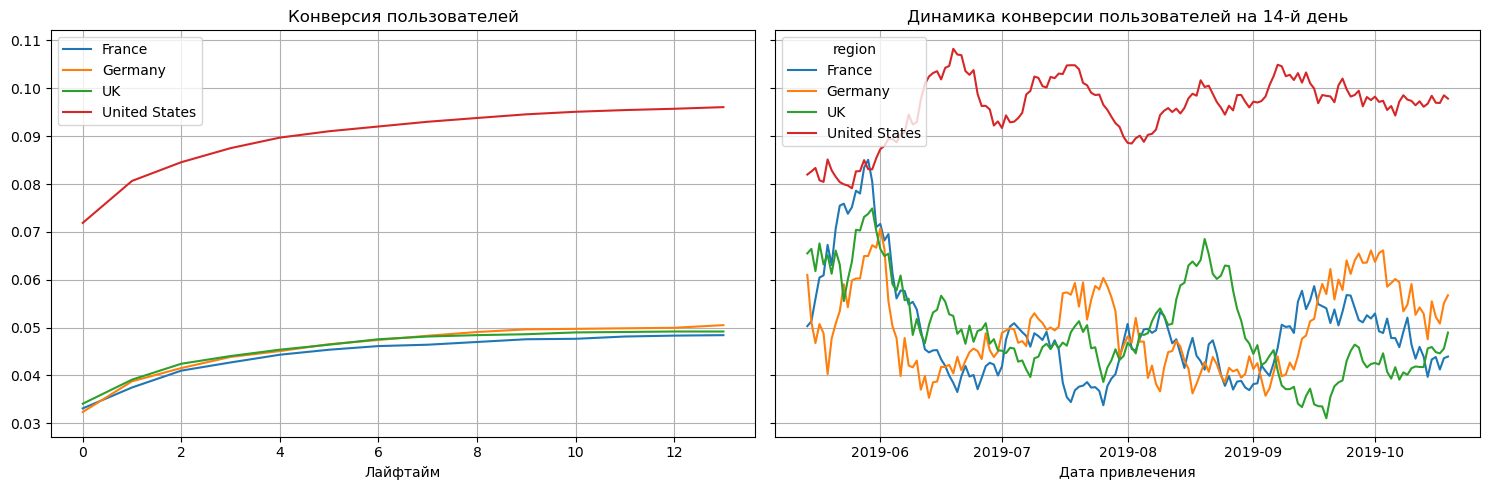

In [39]:
#смотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Пользователи из США почти в два раза лучше конвертируются, чем пользователи из других стран, и так было постоянно уже с середины июня 

### Удержание пользователей с разбивкой по странам, динамика его измененя <a id='5.8'></a>

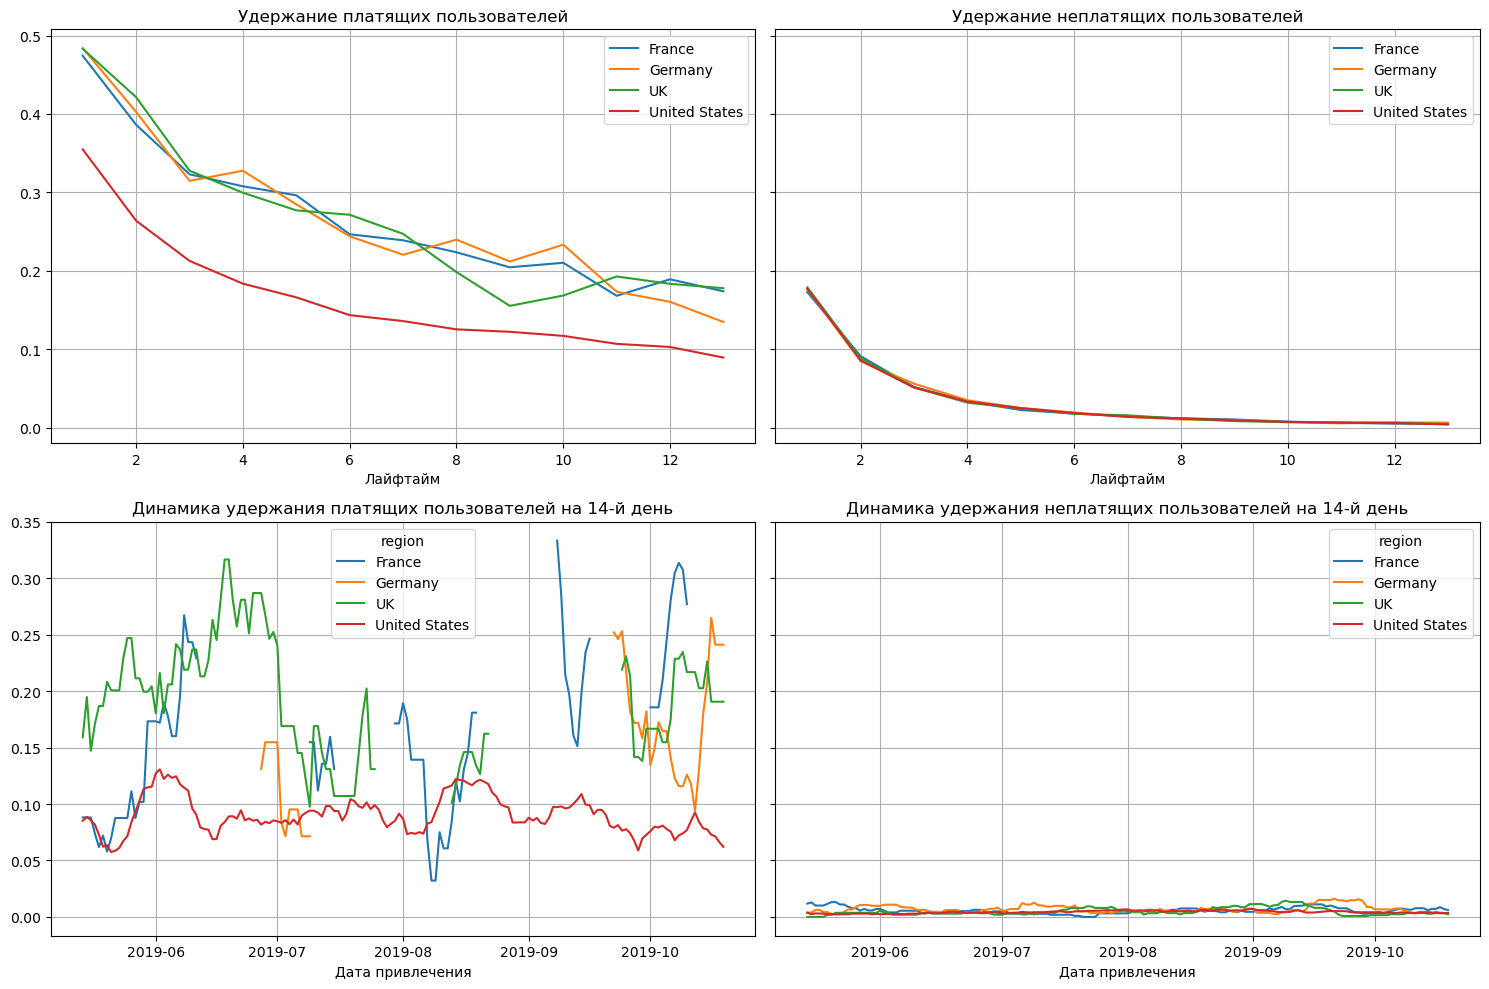

In [40]:
#посмотрим на графики удержания пользователей с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Пользователи из США удерживаются хуже других. И это при том, что они дороже остальных.

### Окупаемость рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, графики динамики LTV, CAC и ROI <a id='5.9'></a>

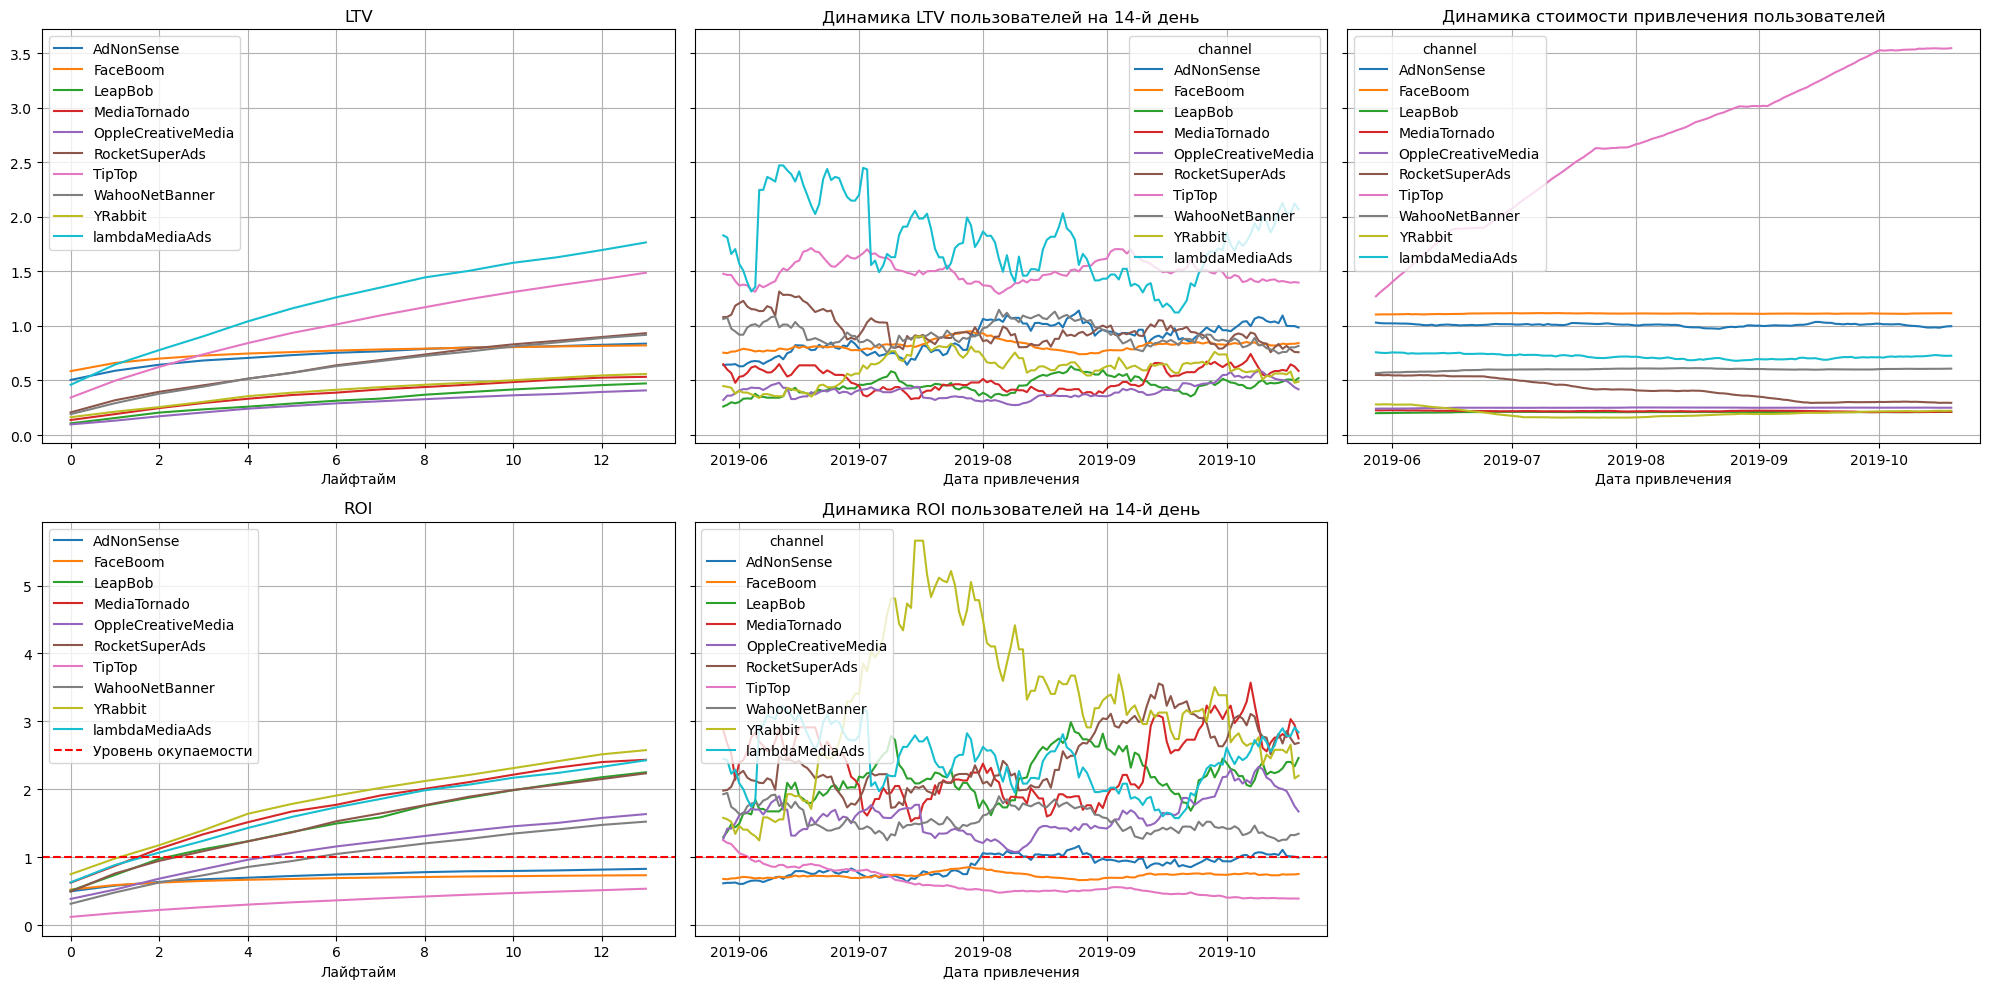

In [41]:
#строим графики LTV и ROI, динамики LTV, CAC и ROI с разбивкой по рекламным каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28)

По графикам с разбивкой по рекламным каналам можем отметить следующие площадки:

- TipTop. Стоисмость привлечения пользователей с этой платформы самая высокая, что не оправдано - пользователи, привлеченные с помощью этой платформы, не окупаются вообще, хоть и показатель LTV довольно высок.

- FaceBoom и AdNonSense. На этих платформах тоже сравнительно большая стоимость привлечения одного пользователя - более 1$. При этом пользователи, привлеченные с помошью этих платформ тоже не окупаются.

- LambdaMediaAds. Самый высокий показатель LTV пользователей среди остальных площадок, показатель ROI один из самых высоких, стабильная окупаемость с течением времени.

- YRabbit. Самый высокий средний показатель ROI, стабильный LTV. Привлекать пользователей с этой площадки стоит осторожно, так как показатель ROI во времени стабильно снижается с середины июля.

- MediaTornado, LeapBob, RocketSuperAds. Достаточно стабильные и выгодные площадки. Пользователи, привлеченные с этих платформ, окупаются за 2 дня, имеют не высокий, но стабильный показатель LTV. При стоимости привлечения пользователя около 0.25$ являются довольно интересными источниками трафика.

### Конверсия пользователей с разбивкой по каналам привлечения, динамика её измененя <a id='5.10'></a>

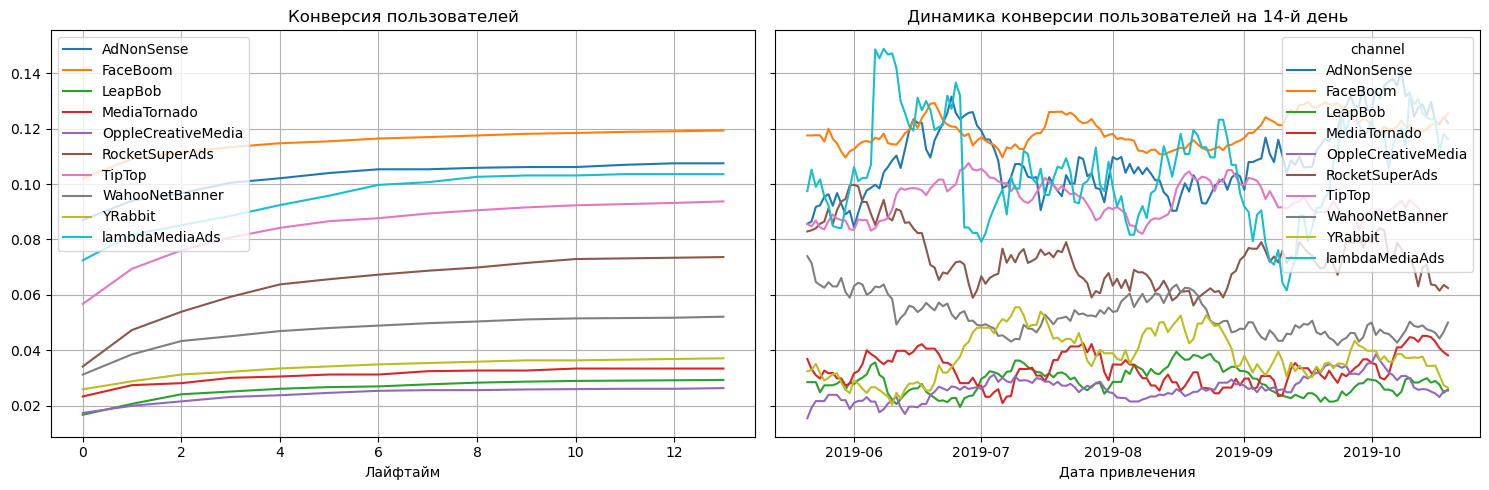

In [42]:
#смотрим конверсию с разбивкой по каналам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=21) 

Лучше всех конвертируются пользователи FaceBoom, затем AdNonSense и LambdaMediaAds. 

Хуже всех - YRabbit, MediaTornado, LeapBob и OppleCreativeMedia.

### Удержание пользователей с разбивкой по каналам привлечения, динамика его измененя <a id='5.11'></a>

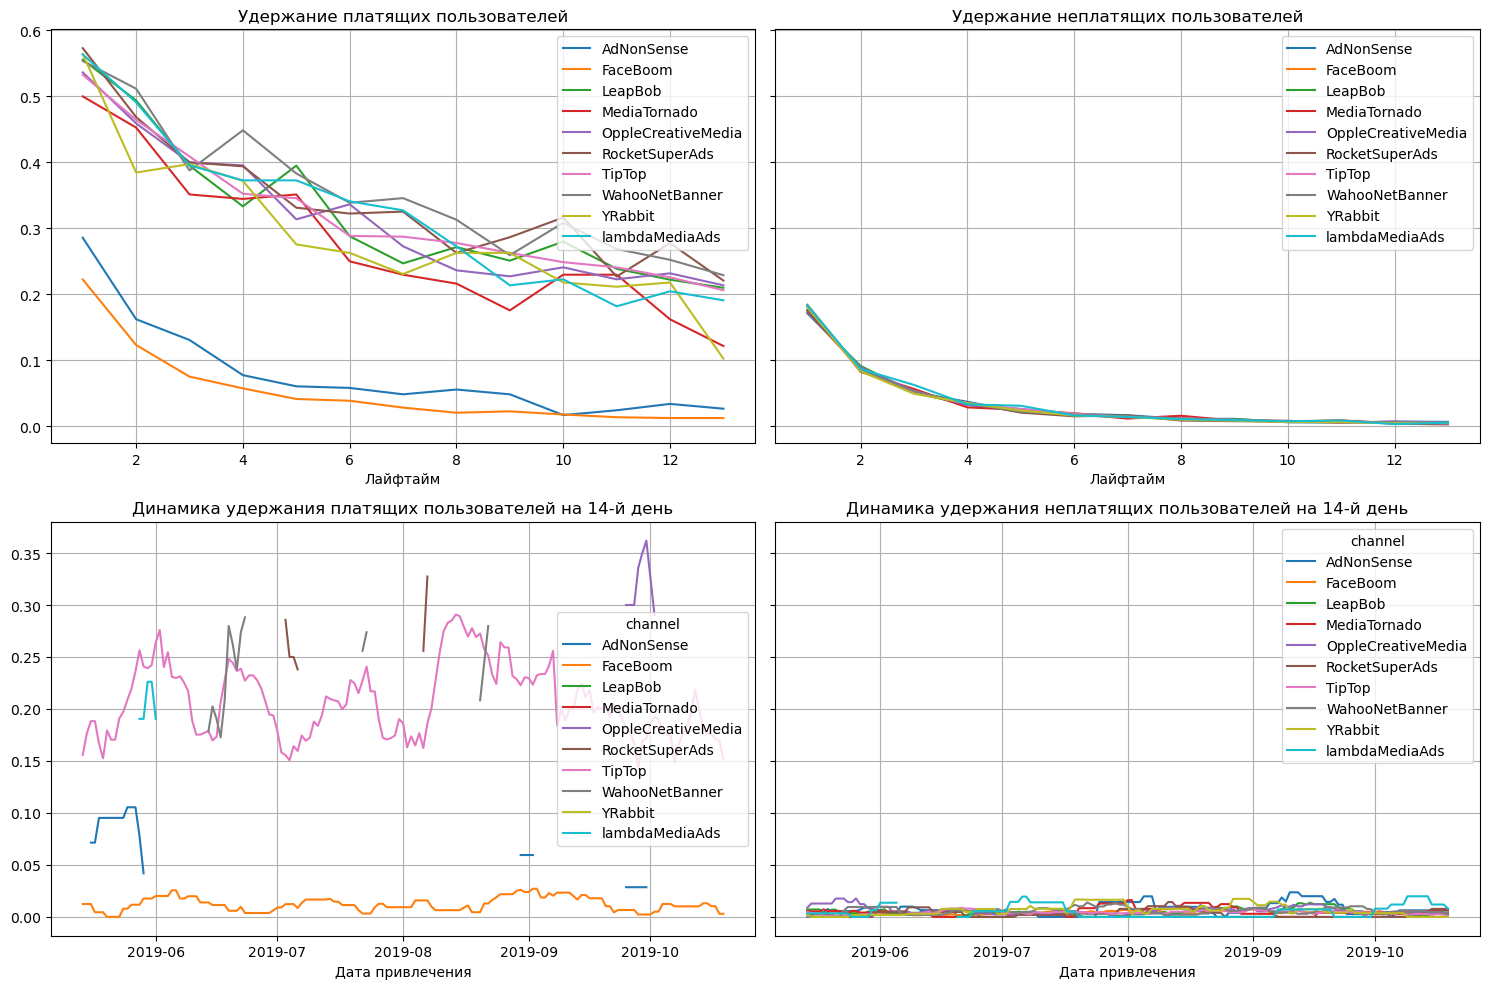

In [43]:
#посмотрим на графики удержания пользователей с разбивкой по каналам привлечения 
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Пользователи, пришедшие из FaceBoom и AdNonSense крайне плохо удерживаются.

### Изучиение отдельно рекламы в США <a id='5.12'></a>

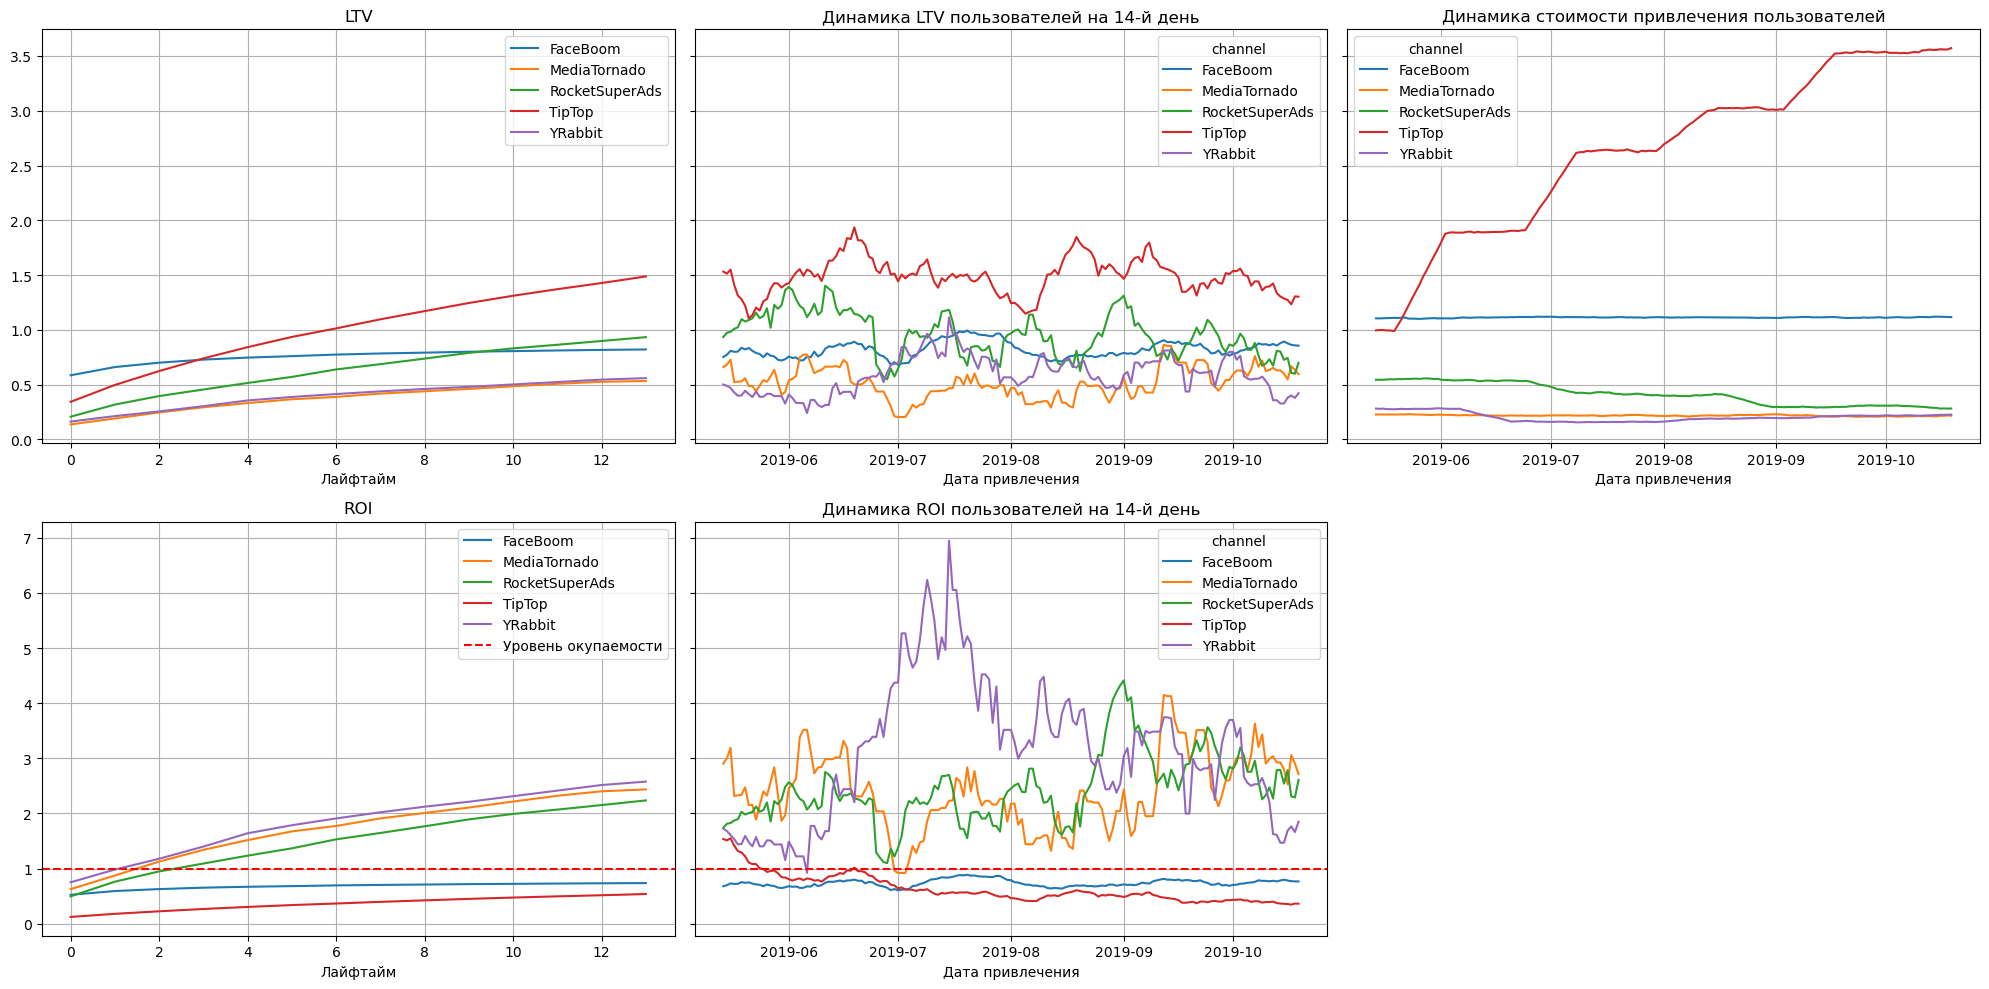

In [44]:
#делаем срез по США
profiles_usa = profiles.query('region == "United States"')

#строим графики LTV и ROI, динамики LTV, CAC и ROI в США с разбивкой по каналам привлечения
ltv_raw_usa, ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(ltv_grouped_usa, ltv_history_usa, roi_grouped_usa, roi_history_usa, horizon_days, window=14)

Видим, что пользователи из США окупаются, просто распределение бюджета по каналам привлечения составлено не верно. В США не окупаются только пользователи, привлеченные из каналов TipTop и FaceBoom, а на них, как мы ранее выяснили, приходится 3/4 всего бюджета.

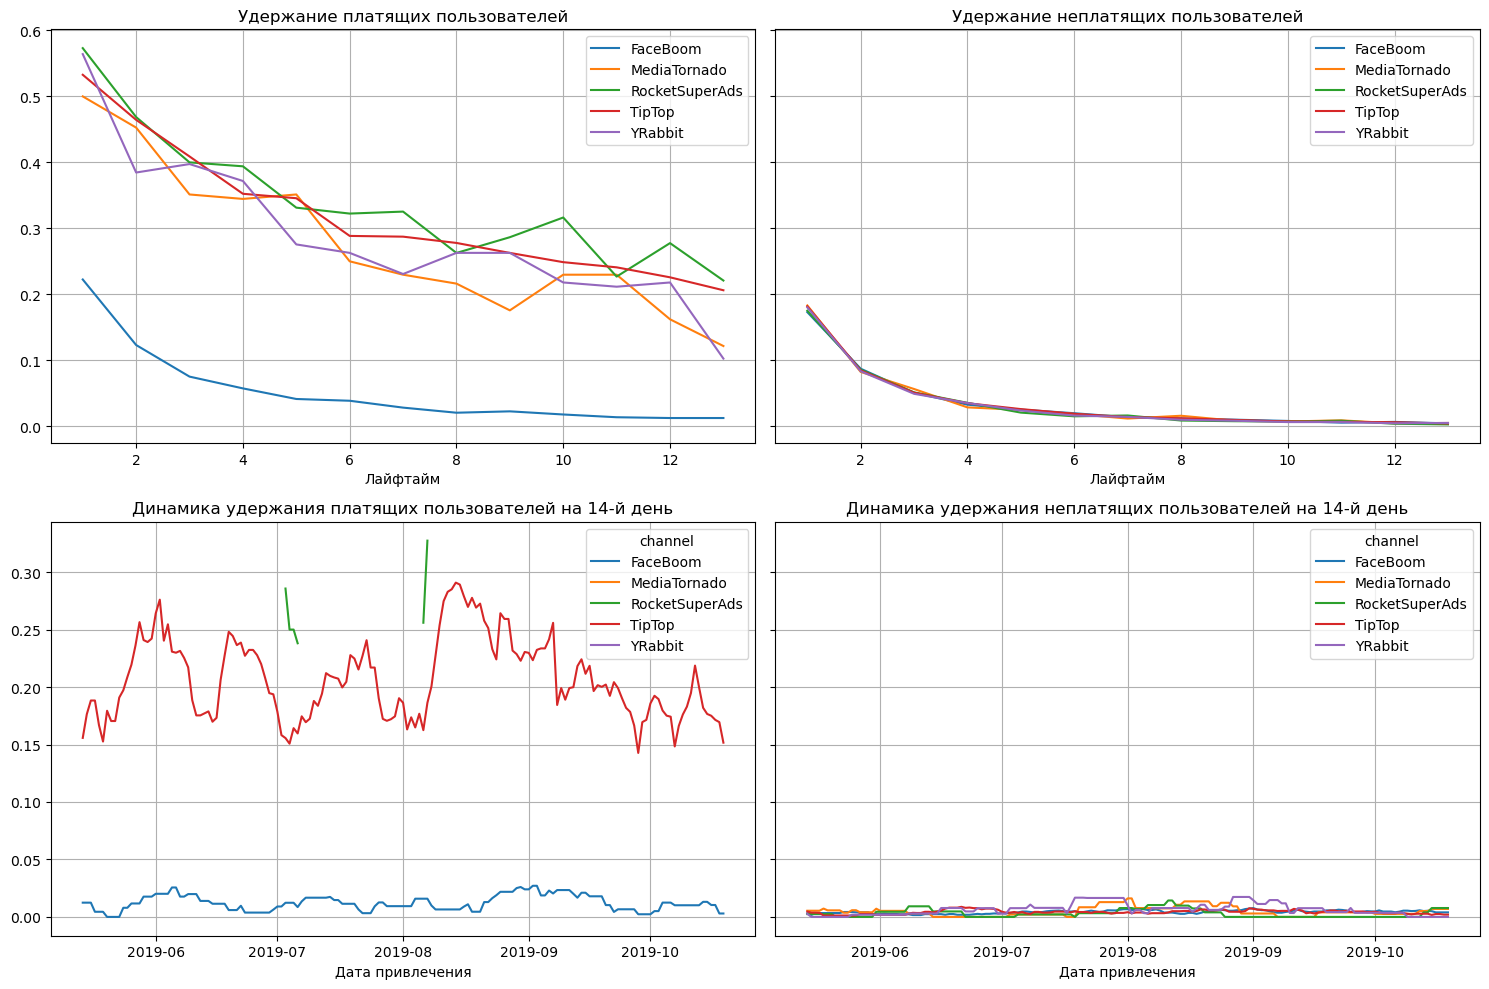

In [45]:
#посмотрим на графики удержания пользователей в США с разбивкой по каналам привлечения
retention_raw_usa, retention_grouped_usa, retention_history_usa = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped_usa, retention_history_usa, horizon_days, window=14)

Удержание FaceBoom в США крайне низкое, а бюджет на эту площадку не маленький, из-за этого в разбивке по странам удержание США было ниже.

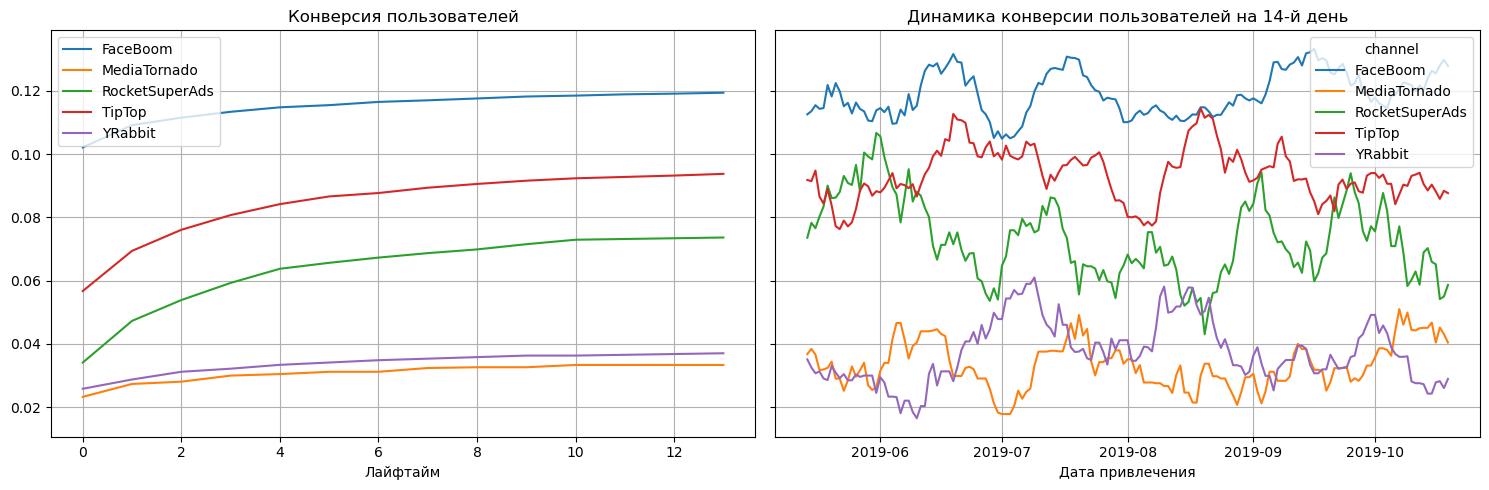

In [46]:
#смотрим конверсию в США с разбивкой по каналам привлечения
conversion_raw_usa, conversion_grouped_usa, conversion_history_usa = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped_usa, conversion_history_usa, horizon_days, window=14)

Зато конверсия FaceBoom в США высокая.

Смотрим на общие графики LTV и ROI без разбивки по когортам. Реклама, направленная на привлечение пользователей в целом не окупается. 14-й лайфтайм пользователей показатель окупаемости рекламы не достигает отметки уровня окупаемости. При этом из графика динамики ROI на 14-й день видно, что реклама на старте кампании окупалась в 1.4 раза, далее в мае резкое снижение окупаемости до 1.0, с середины июня реклама перестала окупаться.

На окупаемость рекламы по устройствам влияют пользователи iPhone и Mac. Пользователи этих устройств не окупаются. При этом стоимость привлечения пользователей на iPhone и Mac выше, чем на остальных платформах.

На окупаемость рекламы по странам сильно влияют пользователи из США: показатель LTV, и его динамика выше, чем в других странах, стоимость привлечения пользователей постоянно увеличивается, на момент анализа разница с другими странами почти в 4 раза.
Пользователи из США не окупаются вообще, в отличие от пользователей из других стран, которые стабильно окупаются на 5-6 день.

На окупаемость рекламы по каналам привлечения влияют пользователи, привлеченные с помощью платформы TipTop и FaceBoom. Стоимость привлечения с платформы TipTop самая высокая, пользователи FaceBoom крайне плохо удерживаются. Пользователи с обеих платформ не окупаются.

Проблемы окупаемости могут быть вызваны двумя факторами: 
- Уклоном на привлечение пользователей из США. Пользователей из этой страны у приложения более чем в 5 раз больше, чем какой либо другой.
- Каналами привлечения пользователей. 40% платящих пользователей привлечены с помощью платформы FaceBoom, 21% - с помошью TipTop. 

## Вывод <a id='6'></a>

Проводим исследование от 1 ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, следовательно, горизонт анализа задаем 14 дней. Чтобы правильно оценить эффективность рекламной кампании исключаем из анализа органических пользователей. 


### Причины неэффективности привлечения пользователей. 

- Реклама преимущественно в США. Таких пользователей более 100 тыс., тогда как пользователей из Великобритании, Франции и Германии не более 18 тыс. в каждой стране. Пользователи из США почти в 2 раза чаще конвертирруются в платящих, но и удерживаются такие пользователи в два раза хуже чем в Великобритании и Франции, и в 1.5 раза хуже, чем в Германии. При этом стоимость их привлечения на момент анализа выше почти в 4 раза. Пользователи из этой страны не окупаются.

- Привлечение новых пользователей из платформы `TipTop`. Половина всего рекламного бюджета была потрачена на пользователей из этой платформы. Эти пользорватели самые дорогие, средняя стоимость привлечения одного составляет 2.8$, что в 2.5 раза дороже чем из `FaceBoom`, и в несколько раз дороже чем из остальных площадок. Доля окупаемости пользователей из `TipTop` составляет 0.5, т.е. затраты на привлечение каждого пользователя в 2 раза превышают сумму его трат в приложении. Это самый низкий показатель из всех площадок привлечения.

- Привлечение новых пользователей из платформы `FaceBoom`. На пользователей этой платформы потрачено 30% рекламного бюджета, средняя стоимость такого пользователя составляет 1.1$, что выше, чем на других площадках, за исключением `TipTop`. Пользователи из `FaceBoom` не окупаются, при этом у них самый низкий, стремящийся к нулю, показатель удержания пользователей.

- Привлечение новых пользователей из платформы `AdNonSense`. Также не удачный выбор канала привлечения новых пользователей, хоть на него и потрачено около 4% рекламного бюджета. Пользователи, пришедшие с этой площадки, не окупались никогда, с момента старта рекламной компании, вплоть до момента анализа. Сравнительно высокая стоимость привлечения клиента (выше только у `TipTop` и `FaceBoom`), крайне низкий показатель удержания пользователей.

- Окупаемость пользователей для всех платформ стабильно снижается со временем, на момент анализа ни одна платформа не окупается. Хуже всех этот показатель у пользователей платформ `iPhone` и `Mac`, также их стоимость привлечения выше, чем на остальных платформах, но и конверсия самая высокая. На протяжении рекламной кампании в среднем окупились только пользователи `PC`, стоимость их привлечения самая низкая, но и конверсия ниже, чем у остальных платформ. Удержание пользователей примерно равное у всех платформ, незначительно выше этот показатель у пользователей `PC`.

### Рекомендации отделу маркетинга
В первую очередь следует изменить стратегию распределения рекламного бюджета по каналам привлечения новых пользователей. От платформ `TipTop`, `FaceBoom` и `AdNonSense` следует полностью отказаться, т.к. пользователи, пришедшие оттуда, не окупаются. 

Обратить внимание в первую очередь стоит на платформу `LambdaMediaAds`: самый высокий показатель LTV пользователей среди остальных площадок, показатель ROI один из самых высоких, стабильная окупаемость с течением времени, высокая конверсия пользователей. С помошью этой площадки стоит привлекать пользователей из EC.

Также, стоит чаще рекламироваться на `RocketSuperAds`. Достаточно стабильная и выгодная площадка. Пользователи, привлеченные с нее  окупаются за 1 день, хороший показатель конверсии, низкая стоимость привлечения, уровень окупаемости к осени вырос, по сравнению с летними месяцами. С помошью этой площадки стоит привлекать пользователей из США.

Еще можно обратить внимание на `WahooNetBanner`. Окупаемость пользователей за 5 дней, не высокая стоимость привлечения, средний показатель конверсии, с течением времени окупаемость стабильна. С помошью этой площадки стоит привлекать пользователей из EC.

В дополнение к вышесказанному стоит обратить внимание на страну привлечения новых пользователей. Уклон стоит сделать на страны ЕС, так как пользователи из этих стран окупаются на 5-6 день использования приложения, имеют стоимость привлечения ниже 0.5$, и их показатель окупаемости не снижается с течением времени. Из этого региона пользователей стоит привлекать преимущественно с помощью площадки `LambdaMediaAds`, реже `WahooNetBanner`. Пользователей из США стоит привлекать только чезез площадку `RocketSuperAds`.
